### Import necessary packages

In [340]:
import numpy as np, pandas as pd, tifffile
from matplotlib import pyplot as plt,colormaps as cm
from matplotlib.gridspec import GridSpec as gs
from roifile import ImagejRoi,ROI_TYPE,roiwrite,roiread
import glob, os, pickle as pk
from skimage import filters

### Helper functions

In [238]:
import numpy as np
from scipy.interpolate import splprep, splev, RectBivariateSpline
from numba import jit
import warnings

def distance(v1, v2):
    """
    Euclidean distance of two points
    :param v1: vecorized coordinate of the first point.
    :param v2: vecorized coordinate of the second point.
    :return: distance between two points.
    """
    return np.sqrt(np.sum((np.array(v1) - np.array(v2)) ** 2))
    
def spline_approximation(n2array, n=200, smooth_factor=1, closed=True):
    warnings.filterwarnings("ignore")
    """
    Updated: 2023.04.12
    Compute a spline approximation of a 2D curve.

    :param n2array: a 2D numpy array of shape (n_points, 2) representing the curve to be approximated
    :param n: number of points of the output polyline/polygon
    :param smooth_factor: smoothing factor for the spline
    :param closed: whether the curve is closed or not
    :return: a 2D numpy array of shape (n, 2) representing the spline approximation of the curve
    """

    if closed:
        tck, u = splprep(n2array.T, u=None, s=smooth_factor, per=1)
    else:
        tck, u = splprep(n2array.T, u=None, s=smooth_factor)
    u_new = np.linspace(u.min(), u.max(), n)
    x_new, y_new = splev(u_new, tck, der=0)
    return np.array([x_new, y_new]).T


def bilinear_interpolate_numpy(im, x, y):
    """
    bilinear interpolation 2D
    :param im: target image
    :param x: x coordinates
    :param y: y coordinates
    :return: interpolated data
    """
    h,l = im.shape
    padded = np.zeros((h+1,l+1))
    padded[:h,:l] += im
    im = padded
    x0 = x.astype(int)
    x1 = x0 + 1
    y0 = y.astype(int)
    y1 = y0 + 1
    Ia = im[x0,y0]
    Ib = im[x0,y1]
    Ic = im[x1,y0]
    Id = im[x1,y1]
    wa = (x1-x) * (y1-y)
    wb = (x1-x) * (y-y0)
    wc = (x-x0) * (y1-y)
    wd = (x-x0) * (y-y0)
    return (Ia*wa) + (Ib*wb) + (Ic*wc) + (Id*wd)


def unit_perpendicular_vector(data, closed=True):
    """
    Compute the unit perpendicular vector of a set of 2D points.

    :param data: A numpy array of shape (n, 2) representing the 2D points.
    :param closed: A boolean indicating whether the curve is closed or not.
    :return: A numpy array of shape (n, 2) representing the unit perpendicular vector of the curve.
    """
    p1 = data[1:]
    p2 = data[:-1]
    dxy = p1 - p2
    ang = np.arctan2(dxy.T[1], dxy.T[0]) + 0.5 * np.pi
    dx, dy = np.cos(ang), np.sin(ang)
    unit_dxy = np.array([dx, dy]).T
    if not closed:
        unit_dxy = np.concatenate([[unit_dxy[0]], unit_dxy])
    else:
        unit_dxy = np.concatenate([unit_dxy, [unit_dxy[0]]])
    return unit_dxy

def measure_length(data, pixel_microns=1):
    """
    Compute the length of a 2D polyline.

    :param data: A numpy array of shape (n, 2) representing the 2D polyline.
    :param pixel_microns: A float representing the conversion factor from pixels to microns.
    :return: A float representing the length of the polyline in microns.
    """
    v1,v2 = data[:-1], data[1:]
    length = np.sqrt(np.sum((np.array(v1) - np.array(v2)) ** 2, axis=1)).sum()*pixel_microns
    return(length)

def simplify_polygon(polygon,
                     tolerance=0.95,
                      interp_distance=1,
                      min_segment_count=2):
    """
    Simplifies a given polygon using the Ramer-Douglas-Peucker algorithm and linear interpolation.

    :param polygon: A 2D numpy array of shape (n, 2) representing the polygon.
    :param tolerance: A float representing the maximum distance for a point to be considered as a candidate for reduction, default value is 0.95.
    :param interp_distance: A float representing the distance between interpolated points, default value is 1.
    :param min_segment_count: An integer representing the minimum number of interpolation points, default value is 2.
    :return: A 2D numpy array of the simplified and interpolated polygon.
    """
    from skimage.measure import approximate_polygon
    if (polygon[0]-polygon[-1]).sum() == 0:
        closed = True
    else:
        closed = False
    approximation = approximate_polygon(polygon,tolerance=tolerance)
    linear_interpolated_segments=[]
    for i in range(len(approximation)-1):
        p1 = approximation[i]
        p2 = approximation[i+1]
        dist = distance(p1,p2)
        steps = max(int(round(dist/interp_distance)),min_segment_count)
        linear_interpolated_segments.append(np.array([np.linspace(p1[0],p2[0],steps),np.linspace(p1[1],p2[1],steps)]).T[:-1])
    linear_interpolated_segments.append(np.array([approximation[-1]]))
    approximated = np.concatenate(linear_interpolated_segments)
    if int(measure_length(approximated)/interp_distance) >= 5:
        approximated = spline_approximation(approximated,
                                            n=int(measure_length(approximated)/interp_distance),
                                            closed=closed,smooth_factor=0)
    return approximated

def offset_by_cross_correlation(v1, v2):
    # Compute cross-correlation
    correlation = np.correlate(v1, v2, mode='full')
    offset = np.argmax(correlation) - (len(v2) - 1)

    return offset

def demograph(sorted_midline,
              sorted_length,
              n=256,
              max_l=8,
              align='center',
              reorient=True,
              forced_reorientation=False,
              reorientation_sequence=[],
              uniformed=False,
              skip_end=0,
              smooth_window=0):
    demograph = []
    _flip_sequence = []

    if forced_reorientation and len(reorientation_sequence) != len(sorted_midline):
        raise ValueError("Lengths don't match!")

    for i, ml in enumerate(sorted_midline):
        _flipped = False
        l = sorted_length[i]
        frac = min(1, l / max_l)
        half_n = int(0.5 * n * frac)
        pad = int(n * 0.5) - half_n
        if smooth_window > 0 and smooth_window % 2 == 1:
            ml = np.convolve(ml, np.ones(smooth_window) / smooth_window, mode='same')
        if skip_end > 0:
            ml = ml[skip_end:-skip_end]

        if reorient:
            if not forced_reorientation:
                ml, _flipped = reorient_data(ml)
            else:
                _flipped = bool(reorientation_sequence[i])
                if _flipped:
                    ml = np.flip(ml)
        _flip_sequence.append(_flipped)

        if not uniformed:
            interpolated = np.interp(x=np.linspace(0, 1, 2 * half_n), xp=np.linspace(0, 1, len(ml)), fp=ml)
            if align == 'center':
                arr = np.pad(interpolated, (pad, pad), 'constant')
            elif align == 'left':
                arr = np.pad(interpolated, (0, 2 * pad), 'constant')
            elif align == 'right':
                arr = np.pad(interpolated, (2 * pad, 0), 'constant')
        else:
            arr = np.interp(x=np.linspace(0, 1, n), xp=np.linspace(0, 1, len(ml)), fp=ml)
        demograph.append(arr)
    return np.array(demograph), np.array(_flip_sequence)


def reorient_data(data):
    half_l = int(round(len(data) / 2))
    flip = bool(data[:half_l].mean() < data.mean())
    if flip:
        data = np.flip(data)
    return data, flip

### Gather data

In [232]:
src = '/Volumes/Extreme_SSD/20241102_divisome_reanalysis/'
midline_dict = {}
for f in sorted(glob.glob(src+'pos*/')):
    pos = int(f.split('/')[-2].split('s')[1].split('-')[0])
    img_id = f.split('/')[-2]
    if pos<15:
        drug = 'RIF'
    else:
        drug = 'INH'
    if drug not in midline_dict:
        midline_dict[drug]={}
    rfp = tifffile.imread(glob.glob(f+'*rfp_bg_subtract.tif')[0])
    gfp = tifffile.imread(glob.glob(f+'*gfp_bg_subtract.tif')[0])
    for i,roi_zip_files in enumerate(sorted(glob.glob(f+'rois/*.zip'))):
        lengths = []
        rfp_profiles = []
        gfp_profiles = []
        coords_list = []
        times = []
        rois = roiread(roi_zip_files)
        cell_id = f'{drug}_{img_id}_{i}'
        for roi in rois:
            t = int(roi.position)-1
            cell_id = f'{drug}_{pos}_{i}_{t}'
            coords = simplify_polygon(np.flip(np.array(roi.subpixel_coordinates),axis=1))
            smoothed = spline_approximation(coords,n=len(coords),closed=False,smooth_factor=3)
            coords_list.append(smoothed)
            lengths.append(measure_length(smoothed)*0.065)
            times.append(t+1)
            rfp_profiles.append(measure_along_strip(smoothed,rfp[t],width=7))
            gfp_profiles.append(measure_along_strip(smoothed,gfp[t],width=7))
        time_argsort = np.argsort(times)
        midline_dict[drug][cell_id] = {'Times':np.sort(times),
                                       'RFP_profiles':[rfp_profiles[i] for i in time_argsort],
                                       'GFP_profiles':[gfp_profiles[i] for i in time_argsort],
                                       'Lengths':[lengths[i] for i in time_argsort],
                                       'Coords':[coords_list[i] for i in time_argsort]}
pk.dump(midline_dict,open('/Volumes/Extreme_SSD/20241102_divisome_reanalysis/merged_midline_dict.pk','wb'))

### Plot kymographs

In [261]:
for drug, drug_dict in midline_dict.items():
    for c,v in drug_dict.items():
        fig=plt.figure(figsize=(5,3))
        grids = gs(1,9,wspace=0.1)
        ax1 = fig.add_subplot(grids[:,:4])
        ax2 = fig.add_subplot(grids[:,4:8])
        ax3 = fig.add_subplot(grids[:,-1])
        
        length = np.max(v['Lengths'])
        max_l = length+0.2
        rfp_demo,_p = demograph(sorted_length=v['Lengths'],
                                sorted_midline=v['RFP_profiles'],max_l=max_l,reorient=False)
        gfp_demo,_p = demograph(sorted_length=v['Lengths'],
                                sorted_midline=v['GFP_profiles'],max_l=max_l,reorient=False)
        x = [np.where(x!=0)[0][np.array([0,-1])]+np.array([-1,1]) for x in gfp_demo]
        x0,x1 = np.array(x).T
        
        ax1.imshow(rfp_demo,aspect='auto',vmin=0,vmax=700)
        ax2.imshow(gfp_demo,aspect='auto')
        
        ax1.plot(x0,np.linspace(-0.5,len(x0)-0.5,len(x0)),lw=3,color='w')
        ax1.plot(x1,np.linspace(-0.5,len(x0)-0.5,len(x0)),lw=3,color='w')
        ax2.plot(x0,np.linspace(-0.5,len(x0)-0.5,len(x0)),lw=3,color='w')
        ax2.plot(x1,np.linspace(-0.5,len(x0)-0.5,len(x0)),lw=3,color='w')
        ax2.set_yticks([])
        ax3.set_yticks([])
        ax1.set_yticks([])
        ax1.set_title('FtsZ-mCherry2B',fontname='Arial',fontsize=16)
        ax2.set_title('RpoB-msfGFP',fontname='Arial',fontsize=16)
        ax3.axis('off')
    
        
        ax3.set_ylim(-0.1,59)
        ax3.set_xlim(0,1)
        ax3.vlines(x=0.5,ymin=23,ymax=59,lw=5,color='g')
        ax3.vlines(x=0.5,ymin=7,ymax=23,lw=5,color='darkorange')
        ax3.vlines(x=0.5,ymin=0,ymax=7,lw=5,color='g')
        ax3.fill_between(x=[0,0.5-0.06],y1=[0,60-v['Times'].max()],y2=[59,59-v['Times'].min()],color='lightgrey')
        ax3.plot([0,0.5-0.08],[59,59-v['Times'].min()],color='black',ls=':')
        ax3.plot([0,0.5-0.08],[0,60-v['Times'].max()],color='black',ls=':')
        ax3.text(0.6,15,'{}\npulse'.format(drug),ha='left',va='center',
                 fontname='Arial',
                 color='darkorange',fontweight='bold')
        ax1.set_xticks(np.linspace(0.5,255.5,5))
        ax1.set_xticklabels(np.round(np.linspace(-max_l/2,max_l/2,5),1))
        ax2.set_xticks([])
        ax1.set_xlabel('distance from\ncenter [µm]',fontname='Arial',fontsize=14)
        plt.savefig('/Volumes/Extreme_SSD/20241102_divisome_reanalysis/plots/{}_kymo.svg'.format(c),
                    bbox_inches='tight',transparent=True)
        plt.close()

### Plot populational stats

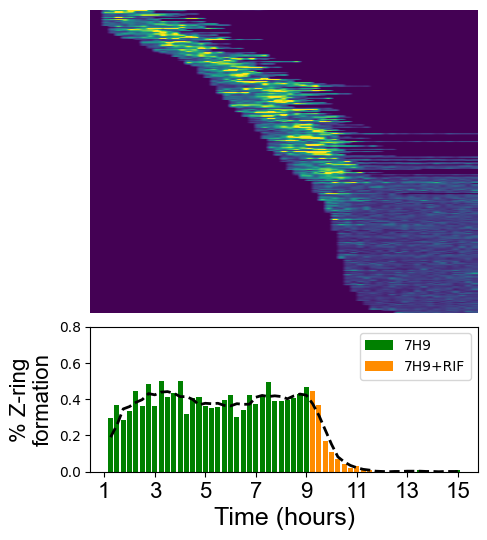

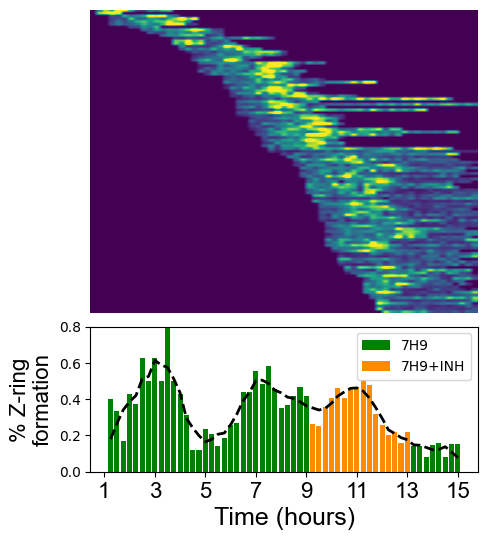

In [388]:

for drug, drug_dict in midline_dict.items():
    birth_times = []
    ftsZ_signal = []
    fig=plt.figure(figsize=(5,6))
    grids = gs(6,1)
    ax1 = fig.add_subplot(grids[:4])
    ax2 = fig.add_subplot(grids[-2:])

    for c,v in drug_dict.items():
        if v['Times'][0]<3 and v['Times'][1]>3:
            v['Times'] = v['Times'][1:]
            v['RFP_profiles'] = v['RFP_profiles'][1:]
        birth_times.append(np.min(v['Times']))
        profile = np.zeros(61)
        signal = [(np.max(x)-np.median(x))/np.median(x) for x in v['RFP_profiles']]
        #signal = np.convolve(signal,np.ones(3)/3,mode='same')
        profile[np.array(v['Times'])] = signal
        ftsZ_signal.append(profile)
    ftsZ_signal = np.vstack(ftsZ_signal)[np.argsort(birth_times)]
    ax1.imshow(ftsZ_signal,aspect='auto',vmax=3,vmin=0)
    ax1.axis('off')
    perc_z_ring = (np.sum(ftsZ_signal>1.5,axis=0)/np.sum(ftsZ_signal>0,axis=0))[5:]
    perc_z_ring_smoothed = np.convolve(perc_z_ring,np.ones(5)/5,mode='same')
    ax2.bar(np.arange(32)+5,perc_z_ring[:32],color='g',label='7H9')
    ax2.bar(np.arange(32+5,61-8),perc_z_ring[32:-8],color='darkorange',label='7H9+{}'.format(drug))
    ax2.bar(np.arange(53,61),perc_z_ring[-8:],color='g')
    ax2.plot(np.arange(len(perc_z_ring))+5,perc_z_ring_smoothed,lw=2,color='black',ls='--')
    ax2.legend()
    ax2.set_ylim(0,0.8)
    ax2.set_xticks([4,12,20,28,36,44,52,60])
    ax2.set_xticklabels([1,3,5,7,9,11,13,15],fontname='Arial',fontsize=16)
    ax2.set_xlabel('Time (hours)',fontname='Arial',fontsize=18)
    ax2.set_ylabel('% Z-ring\nformation',fontname='Arial',fontsize=16)
    plt.savefig('/Volumes/Extreme_SSD/20241102_divisome_reanalysis/{}_z_ring_dynamics.svg'.format(drug),
                bbox_inches='tight',transparent=True)

### Show 

In [331]:
from microfilm.microplot import microshow

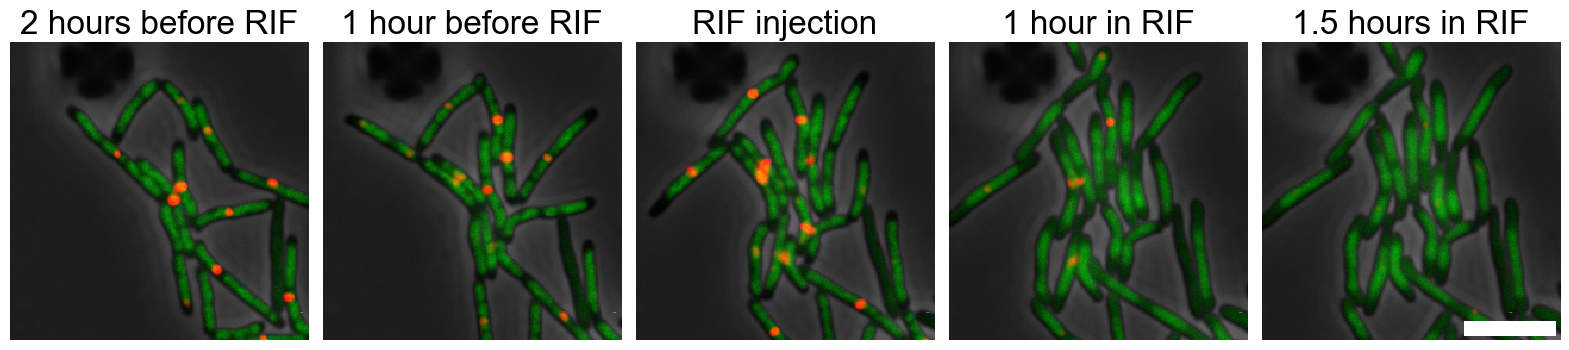

In [381]:
rif_data=tifffile.imread('/Volumes/Extreme_SSD/20241102_divisome_reanalysis/rif_demo.tif')

dranges = [[850,1000],[300,3000],[100,2000]]

fig,axes=plt.subplots(figsize=(20,4),ncols=5,nrows=1,gridspec_kw={'wspace':0.05})
for i,k in enumerate([29,33,37,41,43]):
    img_slice = rif_data[k-1]
    if i == 4:
        scalebar_size_in_units=5
    else:
        scalebar_size_in_units=0
    microshow(images=[filters.gaussian(img_slice[0],sigma=2,
                                       preserve_range=True),
                      img_slice[1],img_slice[2]],fig_scaling=10,
           limits=dranges,
           cmaps=['pure_red','pure_green','gist_gray'],
           unit='µm', scalebar_size_in_units=scalebar_size_in_units,
           scalebar_font_properties={'family':'Arial',},
           scalebar_thickness=0.05,
           scalebar_unit_per_pix=0.065, 
           scalebar_font_size=0,ax=axes[i])
axes[0].set_title('2 hours before RIF',fontsize=24,fontname='Arial')
axes[1].set_title('1 hour before RIF',fontsize=24,fontname='Arial')
axes[2].set_title('RIF injection',fontsize=24,fontname='Arial')
axes[3].set_title('1 hour in RIF',fontsize=24,fontname='Arial')
axes[4].set_title('1.5 hours in RIF',fontsize=24,fontname='Arial')
plt.savefig('/Volumes/Extreme_SSD/20241102_divisome_reanalysis/RIF_z_ring_micrographs.png',dpi=300,
                bbox_inches='tight',transparent=True)

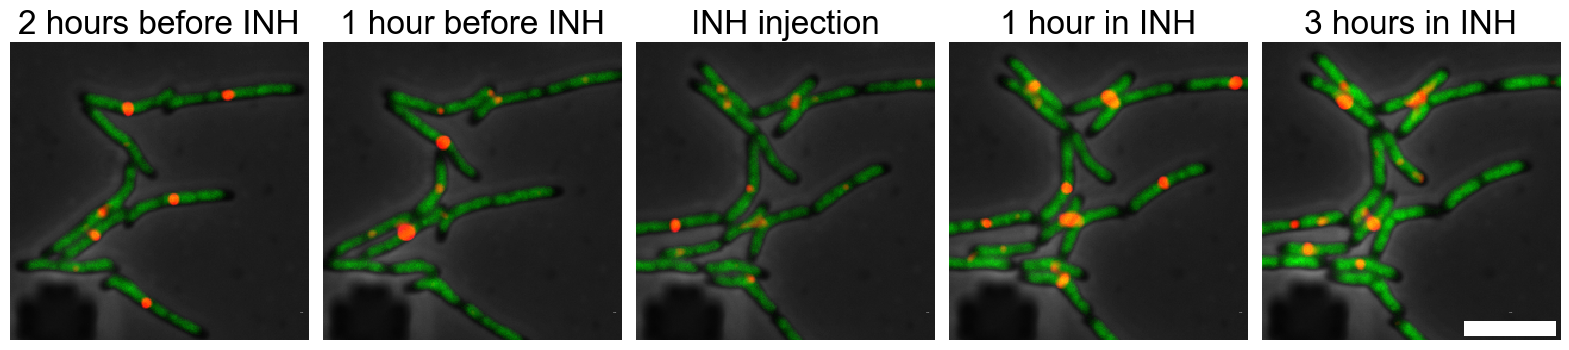

In [382]:
inh_data=tifffile.imread('/Volumes/Extreme_SSD/20241102_divisome_reanalysis/inh_demo.tif')

dranges = [[850,1000],[300,3000],[100,2000]]

fig,axes=plt.subplots(figsize=(20,4),ncols=5,nrows=1,gridspec_kw={'wspace':0.05})
for i,k in enumerate([29,33,37,41,49]):
    img_slice = inh_data[k-1]
    if i == 4:
        scalebar_size_in_units=5
    else:
        scalebar_size_in_units=0
    microshow(images=[filters.gaussian(img_slice[0],sigma=2,
                                       preserve_range=True),
                      img_slice[1],img_slice[2]],fig_scaling=10,
           limits=dranges,
           cmaps=['pure_red','pure_green','gist_gray'],
           unit='µm', scalebar_size_in_units=scalebar_size_in_units,
           scalebar_font_properties={'family':'Arial',},
           scalebar_thickness=0.05,
           scalebar_unit_per_pix=0.065, 
           scalebar_font_size=0,ax=axes[i])
axes[0].set_title('2 hours before INH',fontsize=24,fontname='Arial')
axes[1].set_title('1 hour before INH',fontsize=24,fontname='Arial')
axes[2].set_title('INH injection',fontsize=24,fontname='Arial')
axes[3].set_title('1 hour in INH',fontsize=24,fontname='Arial')
axes[4].set_title('3 hours in INH',fontsize=24,fontname='Arial')
plt.savefig('/Volumes/Extreme_SSD/20241102_divisome_reanalysis/INH_z_ring_micrographs.png',dpi=300,
                bbox_inches='tight',transparent=True)